In [81]:
# coding: utf-8

import os
import random
import itertools

from nltk import word_tokenize
from nltk.tokenize import wordpunct_tokenize

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

In [82]:
negative = [f for f in os.listdir('./review_polarity 2/txt_sentoken/neg') if f.endswith('.txt')]

In [83]:
positive = [f for f in os.listdir('./review_polarity 2/txt_sentoken/pos') if f.endswith('.txt')]

In [84]:
arr_reviews = []

for review in negative:
    with open('./review_polarity 2/txt_sentoken/neg/' + review, 'r', encoding='utf-8') as r:
        dicti = {}
        text = r.read()
        dicti['class'] = 'negative'
        dicti['text'] = text
        arr_reviews.append(dicti)
        
for review in positive:
    with open('./review_polarity 2/txt_sentoken/pos/' + review, 'r', encoding='utf-8') as r:
        dicti = {}
        text = r.read()
        dicti['class'] = 'positive'
        dicti['text'] = text
        arr_reviews.append(dicti)

        
random.shuffle(arr_reviews)  # перемешиваем данные
    
df = pd.DataFrame(arr_reviews)  # создаем датасет


In [85]:
df.head()

,class,text
0,positive,i think the first thing this reviewer should m...
1,positive,1992's alien3 marked not only the death ( by s...
2,positive,i had lost all faith in pg-13 movies that are ...
3,negative,"okay , okay . \nmaybe i wasn't in the mood to ..."
4,negative,don't let this movie fool you into believing t...


In [86]:
df.describe()

,class,text
count,2000,2000
unique,2,2000
top,negative,"summer movies are , by nature , dumb affairs t..."
freq,1000,1


In [87]:
df.groupby('class').describe()

text
class                                                             
negative count                                                1000
         unique                                               1000
         top     summer movies are , by nature , dumb affairs t...
         freq                                                    1
positive count                                                1000
         unique                                               1000
         top     synopsis : shrek ( myers ) is an ogre living i...
         freq                                                    1

In [88]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [89]:
#  Делим выборку в соотновении 80:20
rev_train, rev_test, class_train, class_test = train_test_split(df['text'], df['class'], test_size=0.2)

In [90]:
rev_train.shape, rev_test.shape, class_train.shape, class_test.shape

((1600,), (400,), (1600,), (400,))

### BOW

In [91]:
# Векторизация Bag of Words
bow = CountVectorizer(stop_words='english')
bow.fit_transform(rev_train)
bowed_rev_train = bow.transform(rev_train)  # тренировочные тексты
bowed_rev_test = bow.transform(rev_test)   # тестовые тексты

Добавим удаление стоп слов, потому что это улучшает качество классификации (я проверила)

## DummyClassifier + BOW

In [92]:
# Обучение DummyClassifier
dummy_bow = DummyClassifier(strategy='most_frequent', random_state=0)
dummy_bow = dummy_bow.fit(bowed_rev_train, class_train)

# Вывод результатов по Dummy Classifier
print(classification_report(class_test, dummy_bow.predict(bowed_rev_test)))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00       215
   positive       0.46      1.00      0.63       185

avg / total       0.21      0.46      0.29       400



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## LogisticRegression + BOW

In [93]:
# Обучаем модель логистической регрессии
logit_bow = LogisticRegression(class_weight='balanced')
logit_bow.fit(bowed_rev_train, class_train)

# Вывод результатов по Logistic Regression
print(classification_report(class_test, logit_bow.predict(bowed_rev_test)))

             precision    recall  f1-score   support

   negative       0.86      0.87      0.87       215
   positive       0.85      0.84      0.84       185

avg / total       0.86      0.86      0.86       400



## Confusion matrix (LogisticRegression + BOW)

Confusion matrix, without normalization
[[188  27]
 [ 30 155]]


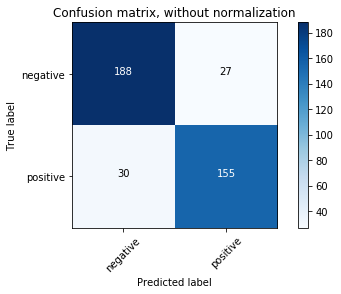

In [94]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(class_test, logit_bow.predict(bowed_rev_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=logit_bow.classes_,
                      title='Confusion matrix, without normalization')
plt.show()

Confusion Matrix позволяет оценить качество вывода классификатора. Элементы по диагонали показывают True Positive, то есть когда предсказанный класс совпадает с true классом. Мы видим, что процент правильных предсказаний очень высокий, значит, классификатор работает достаточно хорошо.

Наша модель логистической регрессии справилась с определением сентимента лучше, чем DummyClassifier

## TF-IDF

In [95]:
# Векторизация TF-IDF
vectorizer = TfidfVectorizer(min_df=5,
                             max_df = 0.8,
                             sublinear_tf=True,
                             use_idf=True,
                             stop_words='english')
tfidf_rev_train = vectorizer.fit_transform(rev_train)
tfidf_rev_test = vectorizer.transform(rev_test)

## DummyClassifier + TF-IDF

In [96]:
# Обучение DummyClassifier
dummy_tfidf = DummyClassifier(strategy='most_frequent', random_state=0)
dummy_tfidf.fit(tfidf_rev_train, class_train)

# Вывод результатов по Dummy Classifier
print(classification_report(class_test, dummy_tfidf.predict(tfidf_rev_test)))

             precision    recall  f1-score   support

   negative       0.00      0.00      0.00       215
   positive       0.46      1.00      0.63       185

avg / total       0.21      0.46      0.29       400



/usr/local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Наша модель справилась с определением сентимента лучше, чем DummyClassifier

## LogisticRegression + TF-IDF

In [97]:
# Обучаем модель логистической регрессии
logit_tfidf = LogisticRegression(class_weight='balanced')
logit_tfidf.fit(tfidf_rev_train, class_train)

# Печатаем результаты классификации
print(classification_report(class_test, logit_tfidf.predict(tfidf_rev_test)))

             precision    recall  f1-score   support

   negative       0.88      0.87      0.87       215
   positive       0.85      0.86      0.86       185

avg / total       0.87      0.86      0.87       400



Confusion matrix, without normalization
[[186  29]
 [ 25 160]]


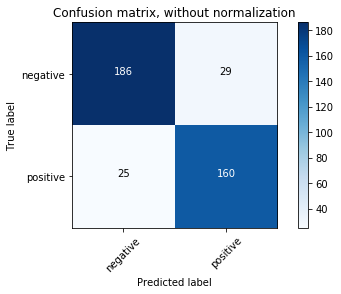

In [98]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(class_test, logit_tfidf.predict(tfidf_rev_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=logit_tfidf.classes_,
                      title='Confusion matrix, without normalization')
plt.show()

Модель логистической регрессии с векторизацией tf-idf работает лучше, чем DummyClassifier

In [99]:
# Обучаем модель Наивный Байес
naive_model = MultinomialNB()
naive_model.fit(bowed_rev_train, class_train)
print(classification_report(class_test, naive_model.predict(bowed_rev_test)))

             precision    recall  f1-score   support

   negative       0.82      0.83      0.83       215
   positive       0.80      0.79      0.80       185

avg / total       0.81      0.81      0.81       400



Confusion matrix, without normalization
[[179  36]
 [ 39 146]]


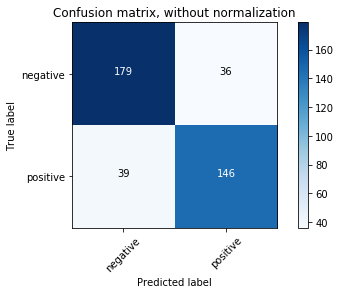

In [100]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(class_test, naive_model.predict(bowed_rev_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=naive_model.classes_,
                      title='Confusion matrix, without normalization')
plt.show()

In [101]:
# Обучаем модель Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(bowed_rev_train, class_train)
print(classification_report(class_test, rf_model.predict(bowed_rev_test)))

             precision    recall  f1-score   support

   negative       0.65      0.73      0.69       215
   positive       0.64      0.55      0.59       185

avg / total       0.65      0.65      0.64       400



Confusion matrix, without normalization
[[157  58]
 [ 83 102]]


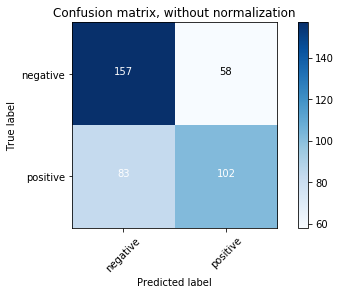

In [102]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(class_test, rf_model.predict(bowed_rev_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=rf_model.classes_,
                      title='Confusion matrix, without normalization')
plt.show()



Лучше всего классифицирует алгоритм Logistic Regression с векторизацией методом TF-IDF с показателем f-score=86%

## Коэффициенты логистической регрессии

In [103]:
logit_bow.coef_

array([[ 0.01,  0.02,  0.  , ..., -0.01,  0.01, -0.  ]])

Положительный коэффициент обозначает, что соответствующий признак увеличивает вероятность класса. Отрицательный коэффициент обозначает, что соответствующий признак уменьшает вероятность класса. Чем больше коэффициент, тем больший вес имеет соответствующий признак. Если коэффициент равен нулю, это означает, что признак не не имеет никакого веса

In [104]:
logit_bow.intercept_

array([-0.42])

In [105]:
logodds = logit_bow.intercept_ + logit_bow.coef_[0] * 2  # compute predicted log-odds for al=2 using the equation
odds = np.exp(logodds)  # convert log-odds to odds
prob = odds/(1 + odds)  # convert odds to probability

In [106]:
logodds

array([-0.4 , -0.38, -0.42, ..., -0.43, -0.4 , -0.42])

In [107]:
odds

array([ 0.67,  0.68,  0.66, ...,  0.65,  0.67,  0.66])

In [108]:
prob

array([ 0.4 ,  0.41,  0.4 , ...,  0.39,  0.4 ,  0.4 ])

In [109]:
# compute predicted probability for al=2 using the predict_proba method
logit_bow.predict_proba(bowed_rev_test[0])[:, 1]

array([ 0.95])

In [110]:
logit_bow.predict(bowed_rev_test[0])

array(['positive'], dtype=object)

In [111]:
def grid_search_function(clf, parameters, X_train, X_test, y_train, y_test):
    gs = GridSearchCV(clf, parameters)
    gs.fit(X_train, y_train)
    print (gs.best_params_)
    y_pred = gs.predict(X_test)
    print(classification_report(y_test, y_pred))

Подберем вручную параметры моделей

In [112]:
rfc_params = {'n_estimators': [20, 40, 60],
              'max_depth': [None, 2, 4],
              'max_leaf_nodes': [None, 2, 4],
              'min_samples_leaf': [1, 2, 3],
              'criterion': ["gini", "entropy"]
             }
grid_search_function(RandomForestClassifier(), rfc_params, bowed_rev_train, bowed_rev_test, class_train, class_test)

{'min_samples_leaf': 1, 'max_leaf_nodes': None, 'n_estimators': 60, 'max_depth': None, 'criterion': 'entropy'}
             precision    recall  f1-score   support

   negative       0.80      0.82      0.81       215
   positive       0.78      0.76      0.77       185

avg / total       0.79      0.79      0.79       400



- n_estimators - это число деревьев
- max_depth - максимальная глубина деева
- min_samples_leaf - наименьшее число примеров, достаточных для узла листа
- criterion - функция, которая измеряет качество разделения (их всего две)

In [113]:
mnb_params = {'alpha': [0, 0.5, 1],
              'fit_prior': [True, False]
             }
grid_search_function(MultinomialNB(), mnb_params, bowed_rev_train, bowed_rev_test, class_train, class_test)

/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
/usr/local/lib/python3.5/site-packages/sklearn/naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) 

{'fit_prior': True, 'alpha': 1}
             precision    recall  f1-score   support

   negative       0.82      0.83      0.83       215
   positive       0.80      0.79      0.80       185

avg / total       0.81      0.81      0.81       400



- alpha - параметр сглаживания
- fit_prior отвечает за то, учитывать ли предыдущие вероятности классов или нет

In [114]:
lg_params = {'penalty': ['l1', 'l2'],
             'fit_intercept': [True, False],
             'C': [.1, 1, 10],
             'class_weight': ['balanced', None],
             'solver': ['liblinear']
            }
grid_search_function(LogisticRegression(), lg_params, bowed_rev_train, bowed_rev_test, class_train, class_test)

{'penalty': 'l2', 'solver': 'liblinear', 'C': 1, 'fit_intercept': True, 'class_weight': 'balanced'}
             precision    recall  f1-score   support

   negative       0.86      0.87      0.87       215
   positive       0.85      0.84      0.84       185

avg / total       0.86      0.86      0.86       400



- penalty - штрафы
- C - значение регуляризации
- class_weight отвечает за веса классов (распределены ли одниково?)

Перебор параметров показал, что наилучшие результаты получаются у модели LogisticRegression с параметрами class_weight=balanced, solver=liblinear. Показатель f-score=86%